In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import corner
from copy import deepcopy
import glob
import operator

from functools import reduce
from scipy.stats import dirichlet

In [2]:
import sys
sys.path.append('../')
from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.bbh_models import read_hdf5
from populations import gw_obs
import seaborn as sns
cp = sns.color_palette("colorblind", 6)


/data/wiay/2297403c/conda_envs/amaze/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
file_path='/data/wiay/2297403c/models_reduced.hdf5'
params = ['mchirp','q', 'chieff', 'z']
channels =['CE', 'CHE', 'GC', 'NSC', 'SMT']

model_names, flow_models = get_models(file_path, channels, params, use_flows=True, device='cpu',\
     no_bins=[5,4,4,5,4], sensitivity='midhighlatelow', use_unityweights=False)
_, kde_models = get_models(file_path, channels, params, use_flows=False, device='cpu',\
    sensitivity='midhighlatelow', use_unityweights=False)


  0%|          | 0/36 [00:00<?, ?it/s]OMP: Warning #96: Cannot form a team with 44 threads, using 42 instead.
OMP: Hint Consider unsetting KMP_DEVICE_THREAD_LIMIT (KMP_ALL_THREADS), KMP_TEAMS_THREAD_LIMIT, and OMP_THREAD_LIMIT (if any are set).
100%|██████████| 36/36 [04:12<00:00,  7.00s/it]


In [8]:
model_names.sort()
hyperparams = sorted(list(set([x.split('/', 1)[1] for x in model_names])))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
hyperparam_dict  = {}
hyperidx=0
while hyperidx < Nhyper:
    hyperidx_with_Nhyper = np.argwhere(np.asarray([len(x.split('/')) for x in hyperparams])>hyperidx).flatten()
    hyperparams_at_level = sorted(set([x.split('/')[hyperidx] for x in np.asarray(hyperparams)[hyperidx_with_Nhyper]]))
    hyperparam_dict[hyperidx] = hyperparams_at_level
    hyperidx += 1
all_models_at_deepest = all([len(x.split('/')[1:])==Nhyper for x in model_names])
while all_models_at_deepest==False:
    # loop until all models have the same length
    for model in model_names:
        # See number of hyperparameters in model, subtract one for channel
        Nhyper_in_model = len(model.split('/'))-1
        kde_hold = getFromDict(kde_models, model.split('/'))
        # loop until this model has all the hyperparam levels as well
        while Nhyper_in_model < Nhyper:
            # remove kde model from old level
            setInDict(kde_models, model.split('/'), {})
            model_names.remove(model)
            for new_hyperparam in hyperparam_dict[Nhyper_in_model]:
                # copy the same kde model for the higher hyperparam level
                new_kde = deepcopy(kde_hold)
                new_level = model.split('/') + [new_hyperparam]
                setInDict(kde_models, new_level, new_kde)
                # add new model name
                model_names.append(model+'/'+new_hyperparam)
            Nhyper_in_model += 1
        model_names.sort()
    # see if all models are at deepest level else repeat
    all_models_at_deepest = all([len(x.split('/')[1:])==Nhyper for x in model_names])

In [7]:
def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

def setInDict(dataDict, mapList, value):
    getFromDict(dataDict, mapList[:-1])[mapList[-1]] = value
    
def get_beta_dets(samples, model_names, pop_models, use_flows):
    detectable_samples = samples.copy()
    smdls = list(set([x.split('/',1)[1] for x in model_names]))
    # get the conversion factors between the detectable and underlying distributions
    for smdl in sorted(smdls):
        detectable_convfacs = []

        hyperparams = smdl.split('/')
        chib_idx = list(submodels_dict[0].keys())[list(submodels_dict[0].values()).index(hyperparams[0])]
        alphaCE_idx = list(submodels_dict[1].keys())[list(submodels_dict[1].values()).index(hyperparams[1])]

        for channel in channels:
            if use_flows:
                if channel == 'CE':
                    detectable_convfacs.append(pop_models[channel].alpha[tuple([chib_idx,alphaCE_idx])])
                else:
                    detectable_convfacs.append(pop_models[channel].alpha[chib_idx])
            else:
                detectable_convfacs.append(getFromDict(pop_models, [channel]+smdl.split('/')).alpha)
        detectable_convfacs = np.asarray(detectable_convfacs)
        # loop over hyperparams to get samples in this submodel
        hyperparams = smdl.split('/')
        for idx, param in enumerate(hyperparams):
            hyper_idx = list(submodels_dict[idx].keys())[list(submodels_dict[idx].values()).index(param)]
            if idx==0:
                matching_idxs = np.where(samples[:,idx] == hyper_idx)[0]
                matching_samps = samples[matching_idxs]
            else:
                matching_idxs = matching_idxs[np.where(matching_samps[:,idx] == hyper_idx)[0]]
                matching_samps = samples[matching_idxs]
        # if no samples are in this model, continue
        if len(matching_idxs)==0:
            continue
        # convert hyperparams of these samples accordingly to get the underlying betas
        converted_betas = detectable_samples[matching_idxs,len(hyperparams):] * detectable_convfacs
        converted_betas /= converted_betas.sum(axis=1, keepdims=True)
        detectable_samples[matching_idxs,len(hyperparams):] = converted_betas
    return(detectable_samples)

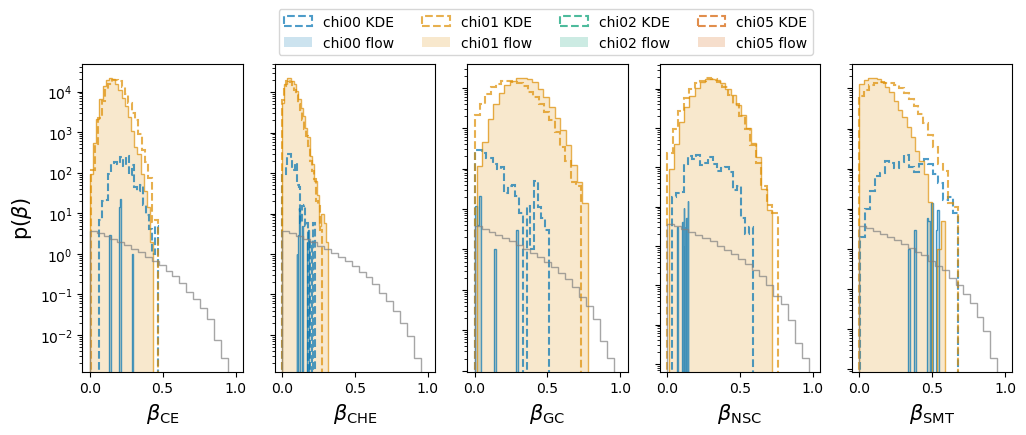

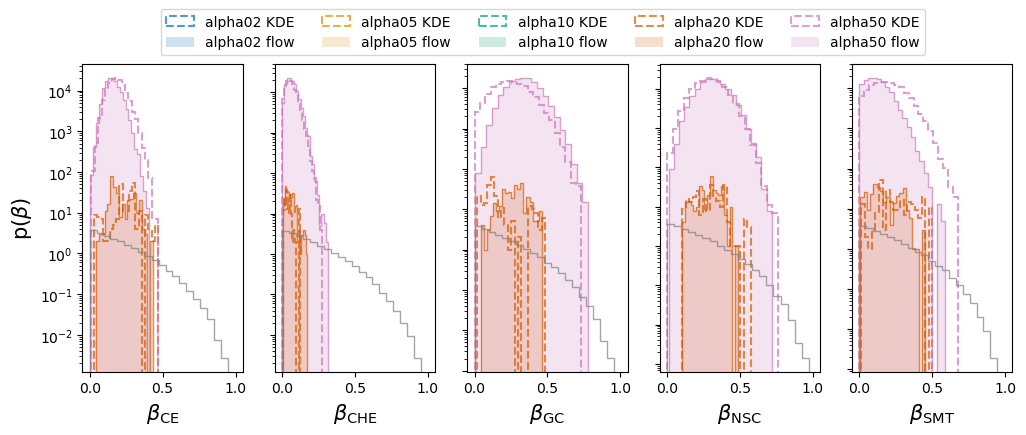

In [11]:
plt.rcParams["figure.figsize"] = (12,4)
kde_file = h5py.File('/data/wiay/2297403c/amaze_model_select/AMAZE_model_selection/rns/KDEs_190824_consistprior/output_seed12.hdf5', 'r')
KDE_samples_allchains = np.hstack([kde_file['model_selection']['samples']['block1_values'], kde_file['model_selection']['samples']['block0_values']])
flow_file = h5py.File('/data/wiay/2297403c/amaze_model_select/AMAZE_model_selection/rns/Flows_190824_consistprior_disc/output_seed12.hdf5', 'r')
flow_samples_allchains = np.hstack([flow_file['model_selection']['samples']['block1_values'], flow_file['model_selection']['samples']['block0_values']])


channels = ['CE','CHE','GC','NSC','SMT']
channel_label =[r'$\beta_{\mathrm{CE}}$',r'$\beta_{\mathrm{CHE}}$',r'$\beta_{\mathrm{GC}}$',r'$\beta_{\mathrm{NSC}}$',r'$\beta_{\mathrm{SMT}}$']

h_max = 0
submodels_dict= {0: {0: 'chi00', 1: 'chi01', 2: 'chi02', 3: 'chi05'}, \
 1: {0: 'alpha02', 1: 'alpha05', 2: 'alpha10', 3: 'alpha20', 4: 'alpha50'}}
Nhyper =2


kde_samps_det = get_beta_dets(KDE_samples_allchains, model_names, kde_models, use_flows=False)
flow_samps_det = get_beta_dets(flow_samples_allchains, model_names, flow_models, use_flows=True)

_concentration = np.ones(len(channels))
beta_p0 =  dirichlet.rvs(_concentration, size=100000)


for hyper_idx in [0,1]:

    fig, ax_margs = plt.subplots(1,5)
    basemdl_samps_kde = len(np.argwhere(kde_samps_det[:,hyper_idx]==0).flatten())
    basemdl_samps_flow = len(np.argwhere(flow_samps_det[:,hyper_idx]==0).flatten())

    for midx, model in submodels_dict[hyper_idx].items():
        kde_smdl_locs = np.argwhere(kde_samps_det[:,hyper_idx]==midx).flatten()
        flow_smdl_locs = np.argwhere(flow_samps_det[:,hyper_idx]==midx).flatten()

        for cidx, channel in enumerate(channels):
            #KDE
            h, bins, _ = ax_margs[cidx].hist(kde_samps_det[kde_smdl_locs, cidx+Nhyper], \
                histtype='step', color=cp[midx], bins=20, ls='--', lw=1.5, \
                alpha=0.7, label=model+' KDE')

            #flow
            h, bins, _ = ax_margs[cidx].hist(flow_samps_det[flow_smdl_locs, cidx+Nhyper], \
                histtype='step', color=cp[midx], bins=20, \
                alpha=0.7)
            h, bins, _ = ax_margs[cidx].hist(flow_samps_det[flow_smdl_locs, cidx+Nhyper], \
                histtype='stepfilled', color=cp[midx], bins=20, \
                alpha=0.2, label=model+' flow')
            h_max = h.max() if h.max() > h_max else h_max

    # format plot
    for cidx, (channel, ax_marg) in enumerate(zip(channels, ax_margs)):
        #plotprior
        h, bins, _ = ax_margs[cidx].hist(beta_p0[:,cidx], \
                histtype='step', color='grey', bins=20, alpha=0.7, density=True)

        ax_marg.set_xlabel(channel_label[cidx], fontsize=15)
        ax_marg.set_yscale('log')
        if cidx == 0:
            ax_marg.set_ylabel(r"p($\beta$)", fontsize=15)
        else:
            ax_marg.tick_params(labelleft=False)

    # legend
    if hyper_idx ==0:
        ax_marg.legend(loc='upper right', bbox_to_anchor=(-.2, 1.2), ncol=4, prop={'size':10})
    elif hyper_idx==1:
        ax_marg.legend(loc='upper right', bbox_to_anchor=(0.5, 1.2), ncol=5, prop={'size':10})
        
    #plt.savefig(f'../plot/paper_plots/test_discreteBFs_{hyper_idx}.pdf', bbox_inches='tight')

In [28]:
beta_p0[0,:]

array([0.12050101, 0.6111995 , 0.05207886, 0.07418719, 0.14203344])

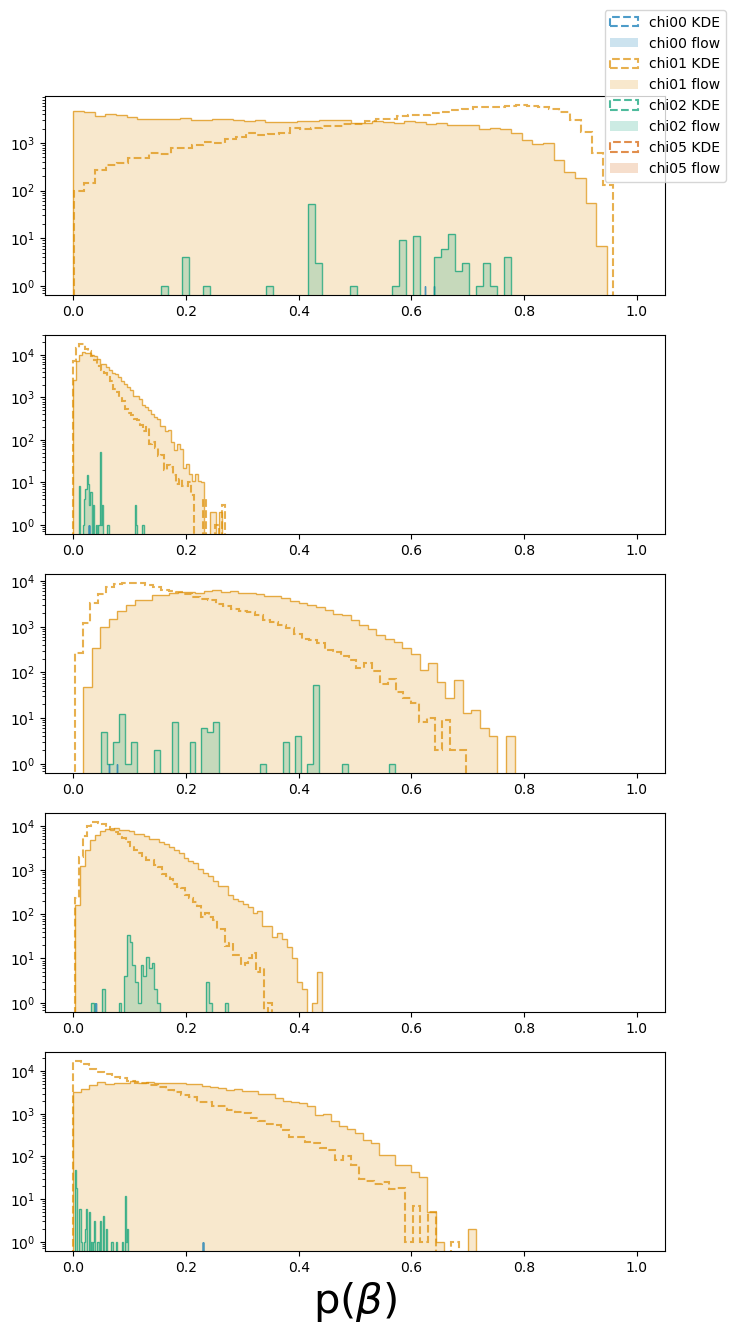

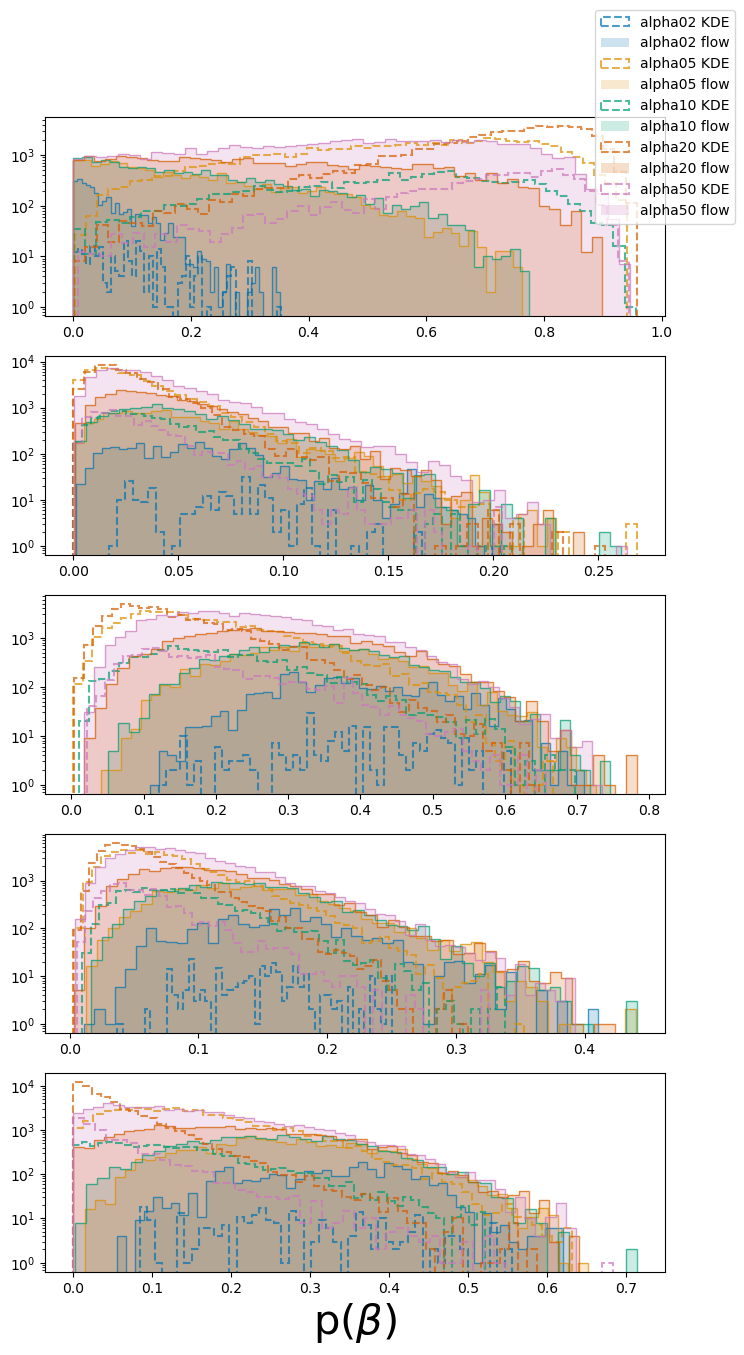

In [5]:
plt.rcParams["figure.figsize"] = (8,15)
kde_file = h5py.File('/data/wiay/2297403c/amaze_model_select/AMAZE_model_selection/rns/KDEs_230624_Gwtc3/output_seed12.hdf5', 'r')
KDE_samples_allchains = np.hstack([kde_file['model_selection']['samples']['block1_values'], kde_file['model_selection']['samples']['block0_values']])
flow_file = h5py.File('/data/wiay/2297403c/amaze_model_select/AMAZE_model_selection/rns/Flows_200624_Gwtc3/output_seed12.hdf5', 'r')
flow_samples_allchains = np.hstack([flow_file['model_selection']['samples']['block1_values'], flow_file['model_selection']['samples']['block0_values']])

channels = ['CE','CHE','GC','NSC','SMT']

h_max = 0
submodels_dict= {0: {0: 'chi00', 1: 'chi01', 2: 'chi02', 3: 'chi05'}, \
 1: {0: 'alpha02', 1: 'alpha05', 2: 'alpha10', 3: 'alpha20', 4: 'alpha50'}}
Nhyper =2


for hyper_idx in [0,1]:
    basemdl_samps_kde = len(np.argwhere(KDE_samples_allchains[:,hyper_idx]==0).flatten())
    basemdl_samps_flow = len(np.argwhere(flow_samples_allchains[:,hyper_idx]==0).flatten())

    fig, ax_margs = plt.subplots(5)
    for midx, model in submodels_dict[hyper_idx].items():
        kde_smdl_locs = np.argwhere(KDE_samples_allchains[:,hyper_idx]==midx).flatten()
        flow_smdl_locs = np.argwhere(flow_samples_allchains[:,hyper_idx]==midx).flatten()

        mdl_samps = len(kde_smdl_locs)
        """if basemdl_samps > 0:
            BF = float(mdl_samps)/basemdl_samps
        else:
            BF = float(mdl_samps)"""
        for cidx, channel in enumerate(channels):
            h, bins, _ = ax_margs[cidx].hist(KDE_samples_allchains[kde_smdl_locs, cidx+Nhyper], \
                histtype='step', color=cp[midx], bins=50, ls='--', lw=1.5, \
                alpha=0.7, label=model+' KDE')

            h, bins, _ = ax_margs[cidx].hist(flow_samples_allchains[flow_smdl_locs, cidx+Nhyper], \
                histtype='step', color=cp[midx], bins=50, \
                alpha=0.7)
            h, bins, _ = ax_margs[cidx].hist(flow_samples_allchains[flow_smdl_locs, cidx+Nhyper], \
                histtype='stepfilled', color=cp[midx], bins=50, \
                alpha=0.2, label=model+' flow')
            h_max = h.max() if h.max() > h_max else h_max

    # format plot
    for cidx, (channel, ax_marg) in enumerate(zip(channels, ax_margs)):

        # legend
        if cidx == 0:
            ax_marg.legend(loc='center', bbox_to_anchor=[1.0,1.0], prop={'size':10})

        if cidx == len(channels)-1:
            ax_marg.set_xlabel(r"p($\beta$)", fontsize=30)

        ax_marg.set_yscale('log')
    plt.show()

In [12]:
plt.rcParams["figure.figsize"] = (15,15)
ls = ['-', '--', ':', '-.', '--']



channels = ['CE','CHE','GC','NSC','SMT']

def plot_BFs_seeds(filenames, second_files=None, labels = [None,None]):
    h_max = 0
    submodels_dict= {0: {0: 'chi00', 1: 'chi01', 2: 'chi02', 3: 'chi05'}, \
    1: {0: 'alpha02', 1: 'alpha05', 2: 'alpha10', 3: 'alpha20', 4: 'alpha50'}}
    Nhyper =2

    for hyper_idx in [0, 1]:
        fig, ax_margs = plt.subplots(5,len(filenames))

        for i, filename in enumerate(filenames):

            try:
                file = h5py.File(filename, 'r')
            except:
                continue
            samples_allchains = np.hstack([file['model_selection']['samples']['block1_values'], file['model_selection']['samples']['block0_values']])
            basemdl_samps = len(np.argwhere(samples_allchains[:,hyper_idx]==0).flatten())

            if second_files:
                try:
                    comp_file = h5py.File(second_files[i], 'r')
                except:
                    continue
                
                samples_allchains_comp = np.hstack([comp_file['model_selection']['samples']['block1_values'], comp_file['model_selection']['samples']['block0_values']])
                basemdl_samps_comp = len(np.argwhere(samples_allchains_comp[:,hyper_idx]==0).flatten())

            for midx, model in submodels_dict[hyper_idx].items():
                smdl_locs = np.argwhere(samples_allchains[:,hyper_idx]==midx).flatten()

                if second_files:
                    comp_smdl_locs = np.argwhere(samples_allchains_comp[:,hyper_idx]==midx).flatten()

                for cidx, channel in enumerate(channels):
                    h, bins, _ = ax_margs[cidx, i].hist(samples_allchains[smdl_locs, cidx+Nhyper], \
                        histtype='step', color=cp[midx], bins=50, ls='-', lw=1.5+(0.2*i), \
                        alpha=0.7, label=model+labels[0])
                    if second_files:
                        h, bins, _ = ax_margs[cidx, i].hist(samples_allchains_comp[comp_smdl_locs, cidx+Nhyper], \
                            histtype='stepfilled', color=cp[midx], bins=50, \
                            alpha=0.3, label=model+labels[1])
                        h, bins, _ = ax_margs[cidx, i].hist(samples_allchains_comp[comp_smdl_locs, cidx+Nhyper], \
                            histtype='step', color=cp[midx], bins=50, \
                            alpha=0.7)
                    h_max = h.max() if h.max() > h_max else h_max

            # format plot
            for cidx, (channel, ax_marg) in enumerate(zip(channels, ax_margs)):

                # legend
                if i==0:
                    ax_marg[i].set_ylabel(f"{channel}", fontsize=30)
                    
                if cidx == 0 and i ==len(filenames)-1:
                    ax_marg[i].legend(loc='center', bbox_to_anchor=[1.2,1.0], prop={'size':10})

                if cidx == len(channels)-1:
                    ax_marg[i].set_xlabel(r"$\beta$", fontsize=30)

                ax_marg[i].set_yscale('log')

In [13]:
glob.glob('Flows_290724_noprior0_disc/*.hdf5')

['Flows_290724_noprior0_disc/output_seed89_highreg.hdf5',
 'Flows_290724_noprior0_disc/output_seed314_highreg.hdf5',
 'Flows_290724_noprior0_disc/output_seed314.hdf5',
 'Flows_290724_noprior0_disc/output_highreg.hdf5',
 'Flows_290724_noprior0_disc/output.hdf5',
 'Flows_290724_noprior0_disc/output_seed12.hdf5',
 'Flows_290724_noprior0_disc/output_seed12_highreg.hdf5',
 'Flows_290724_noprior0_disc/output_seed89.hdf5']

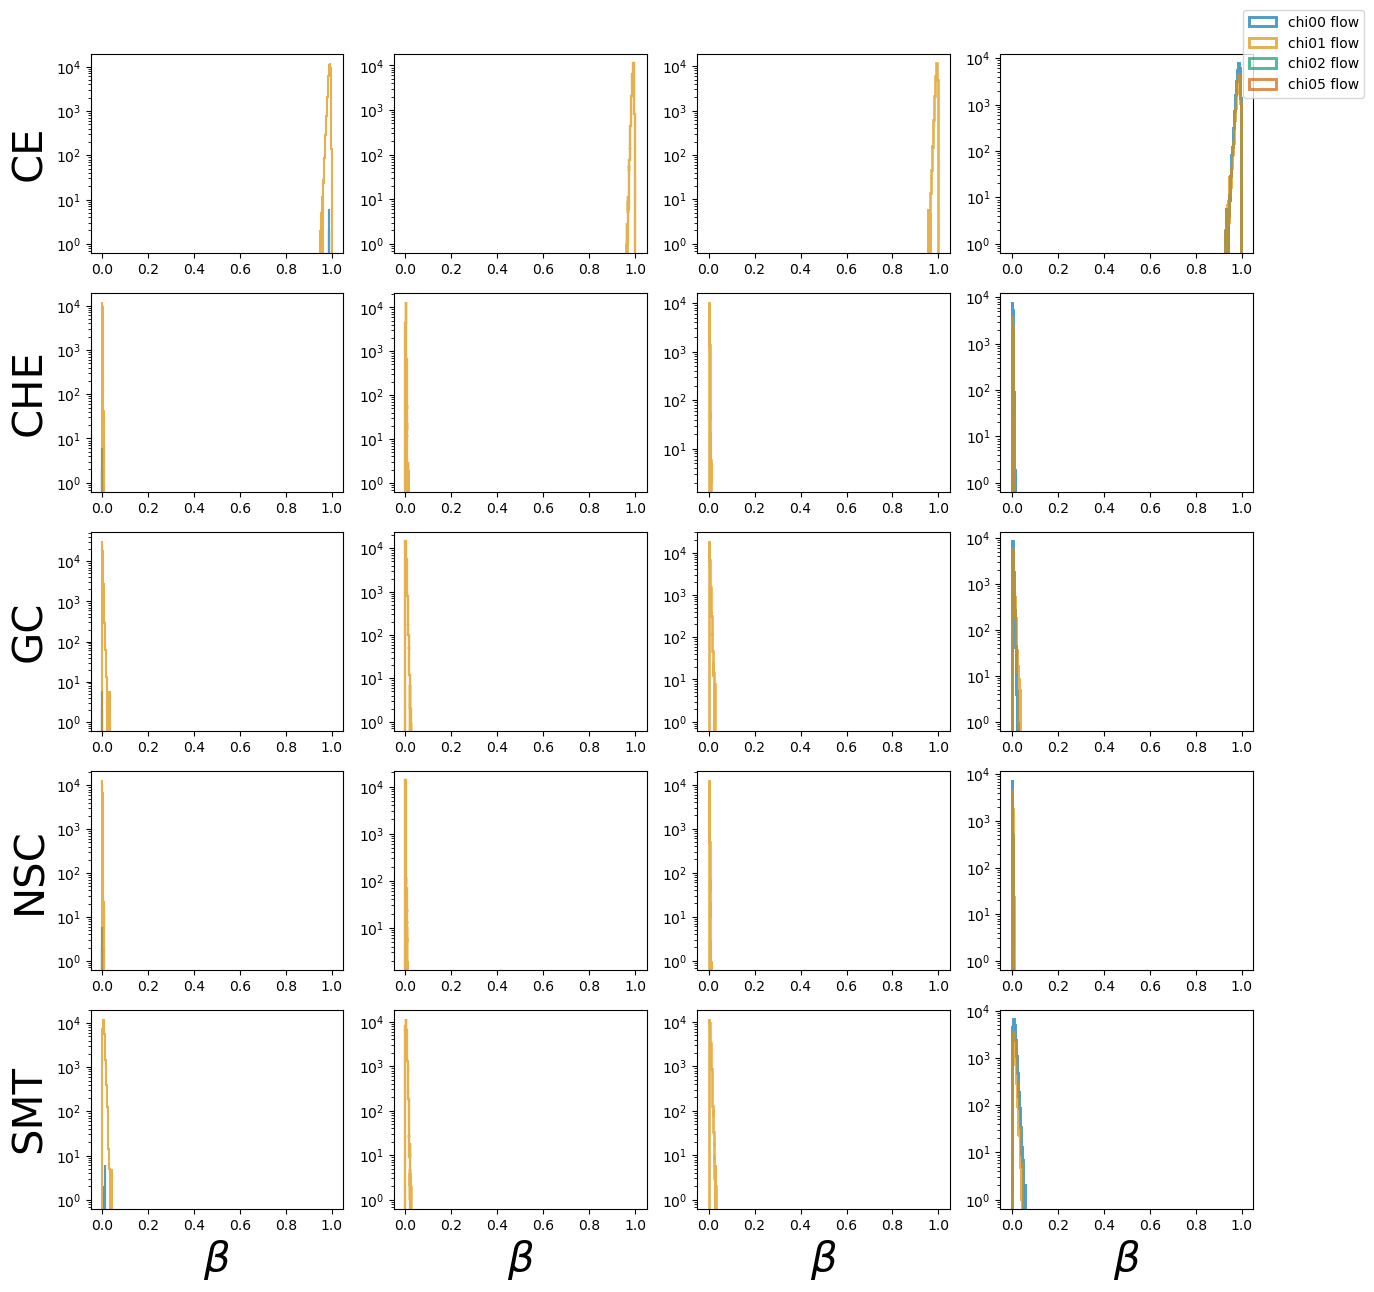

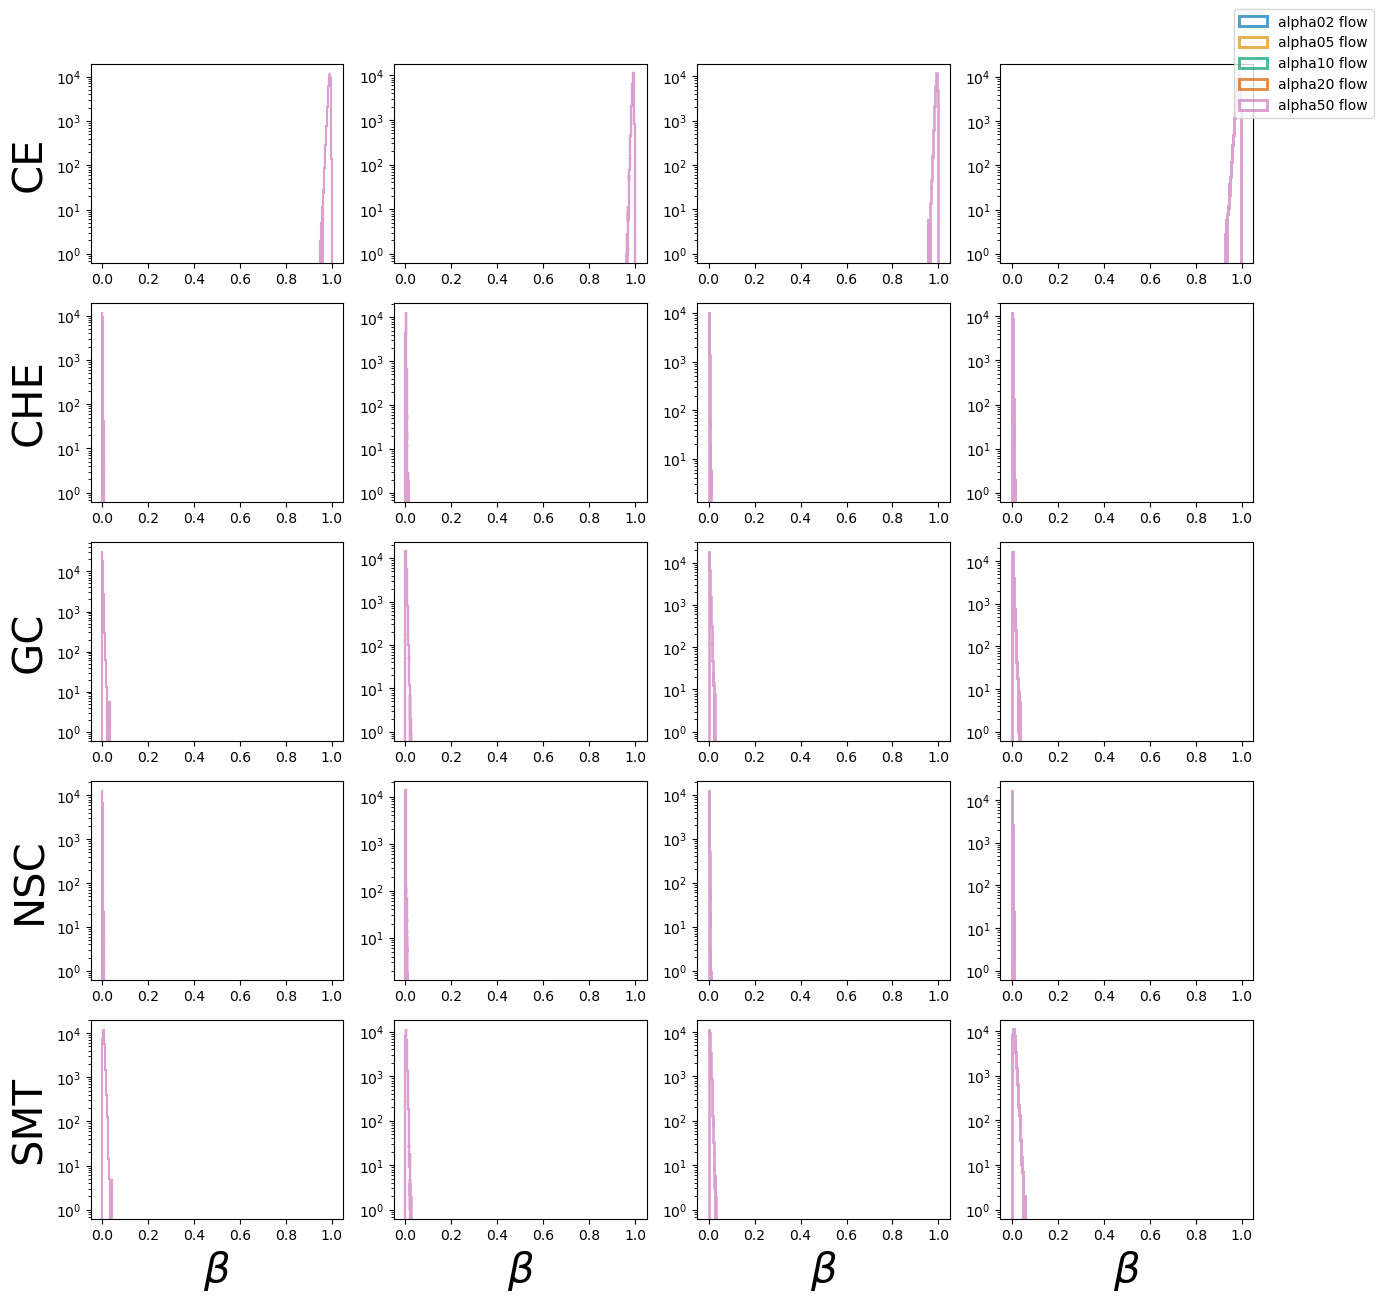

In [14]:
KDE_files = ['KDEs_290725_noprior0/output_seed89_highreg.hdf5',
 'KDEs_290725_noprior0/output_seed314_highreg.hdf5',
 'KDEs_290725_noprior0/output_highreg.hdf5',
 'KDEs_290725_noprior0/output_seed12_highreg.hdf5']

flow_lowreg = [
 'Flows_290724_noprior0_disc/output_seed314.hdf5',
 'Flows_290724_noprior0_disc/output.hdf5',
 'Flows_290724_noprior0_disc/output_seed12.hdf5',
 'Flows_290724_noprior0_disc/output_seed89.hdf5']

plot_BFs_seeds(flow_lowreg, labels=[' flow'])

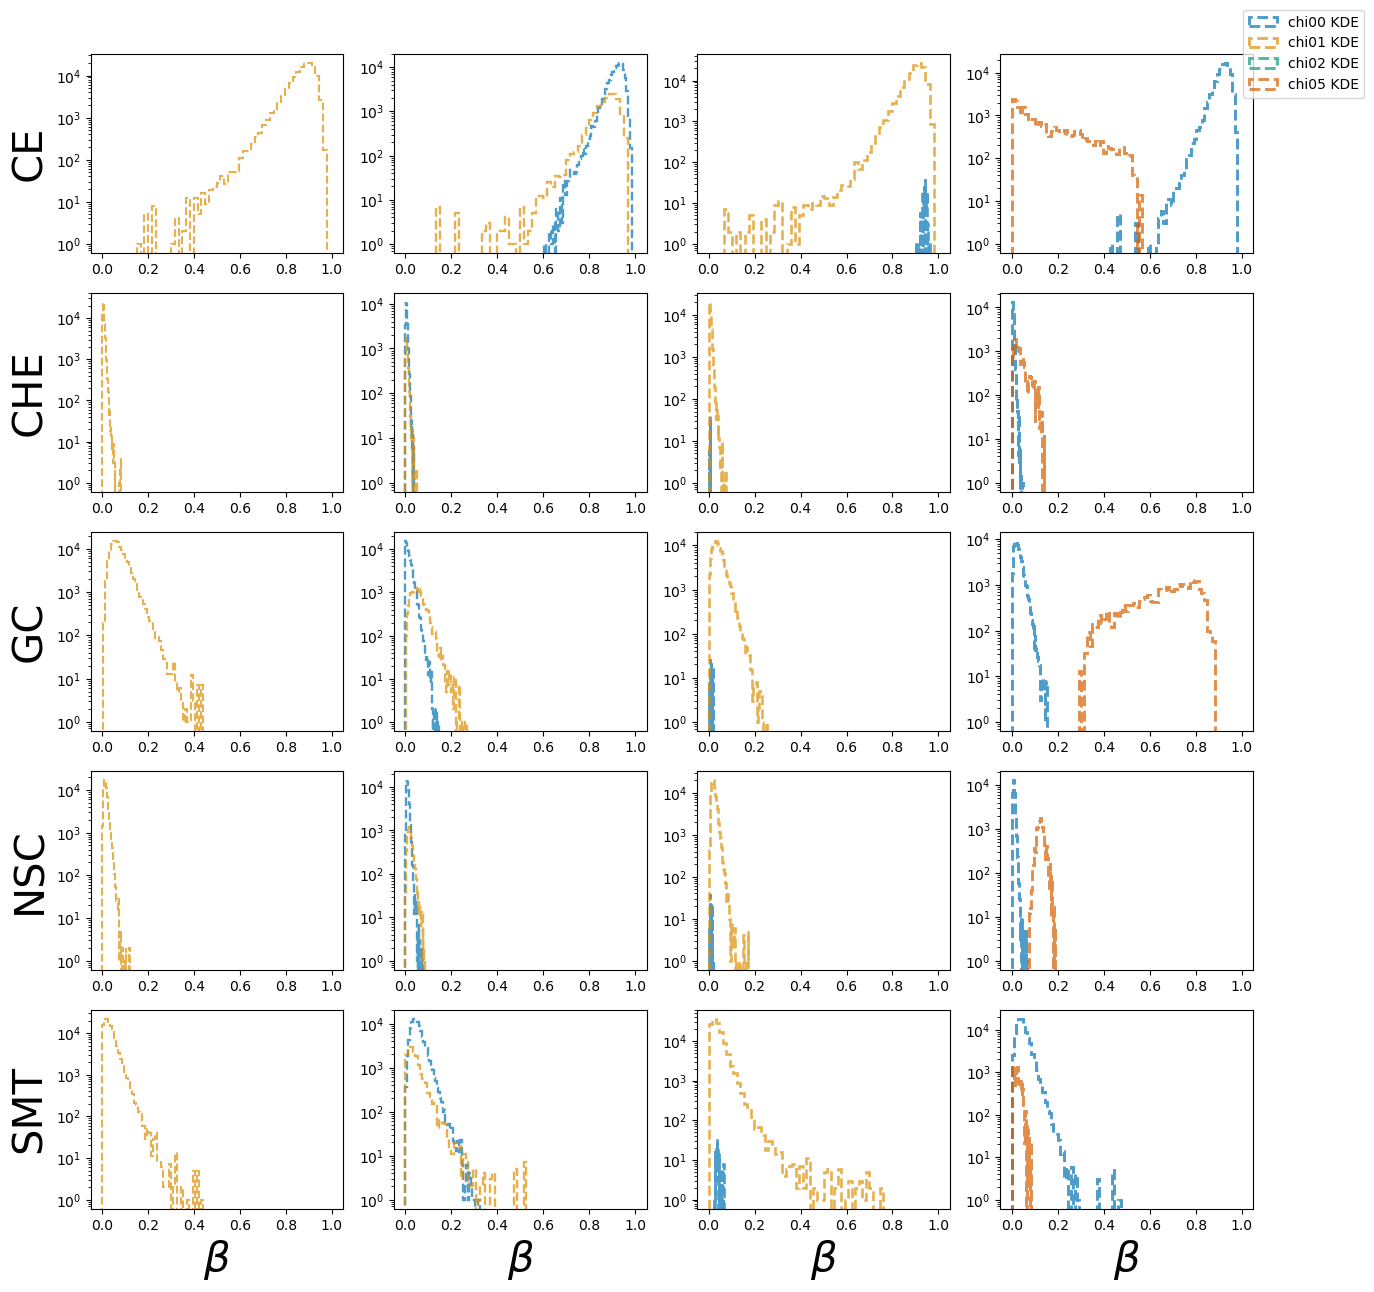

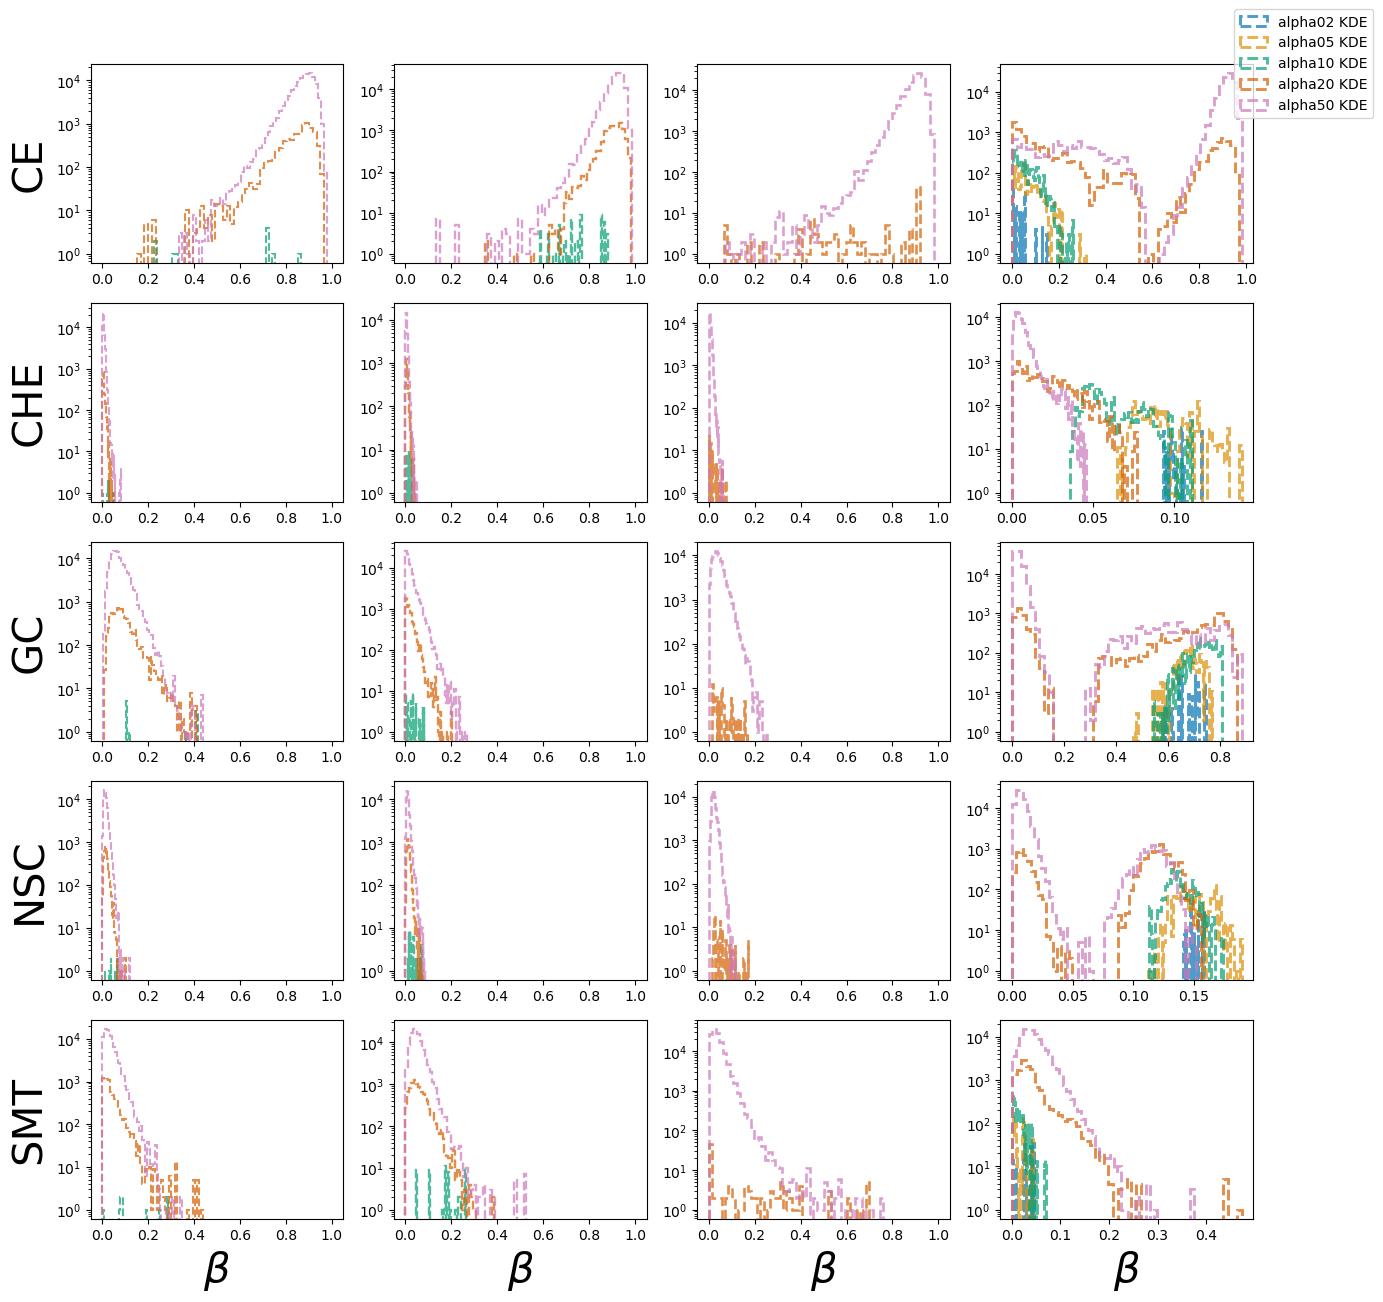

In [61]:
plot_BFs_seeds(KDE_files, labels=[' KDE', None])

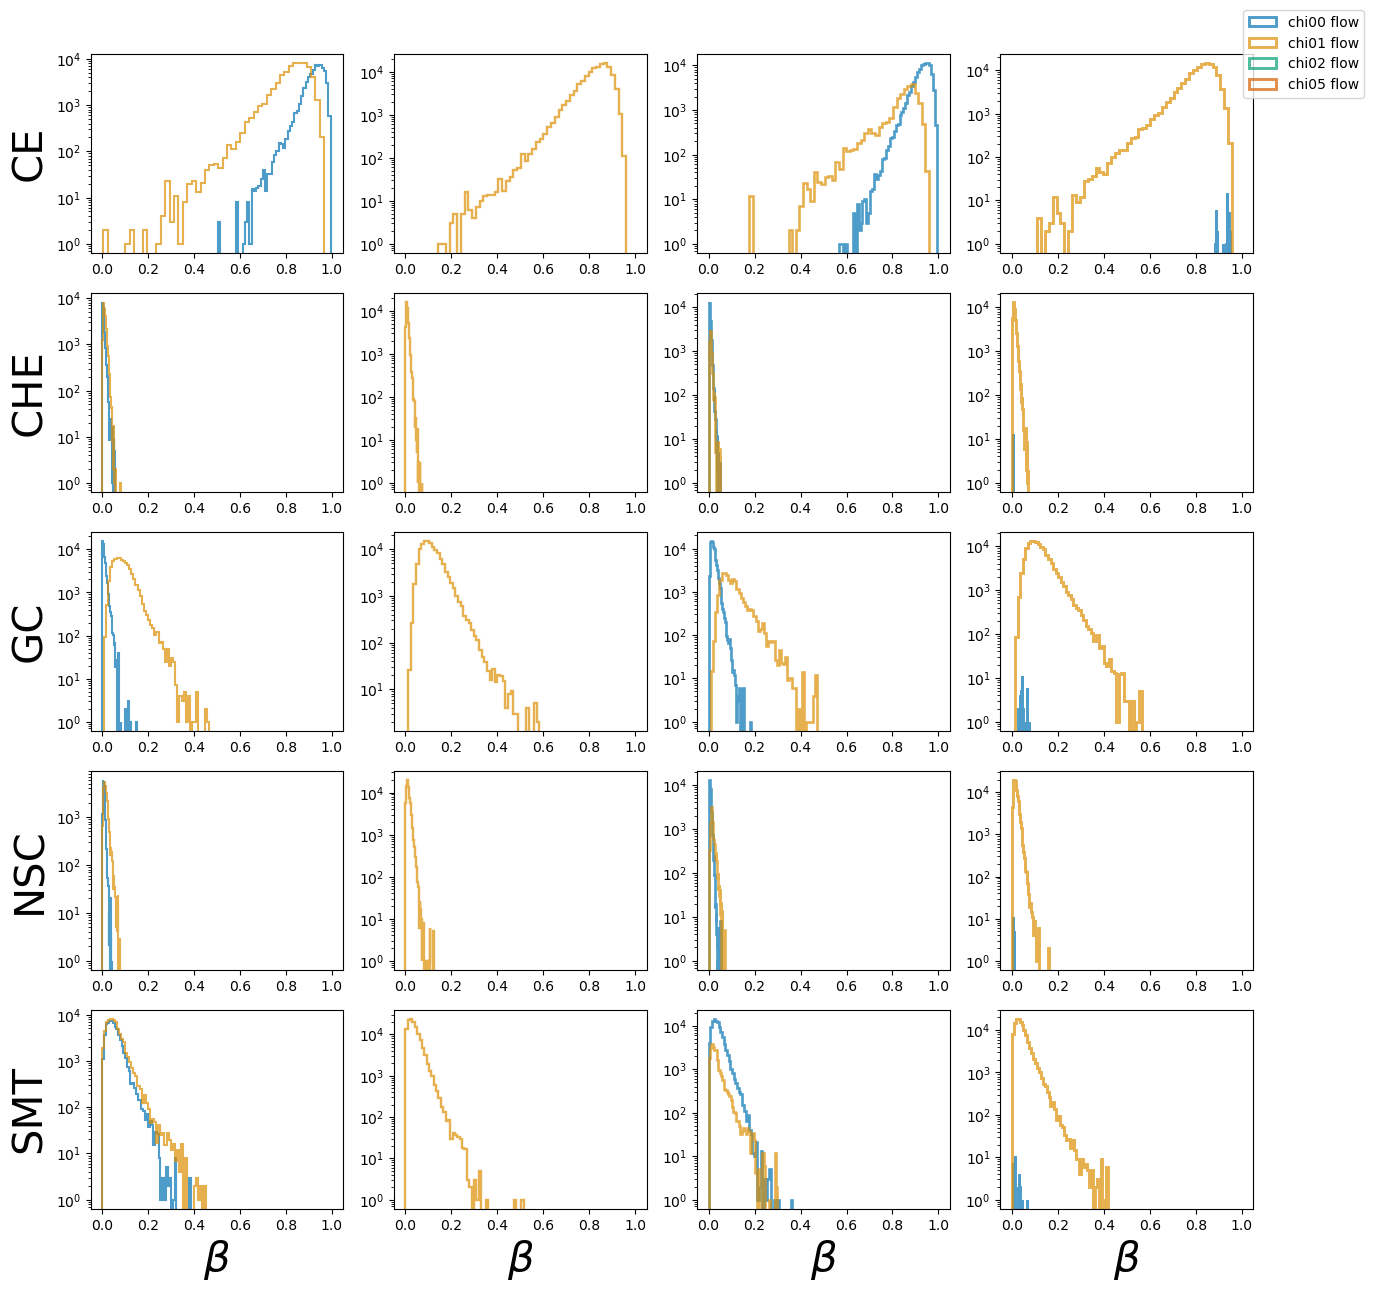

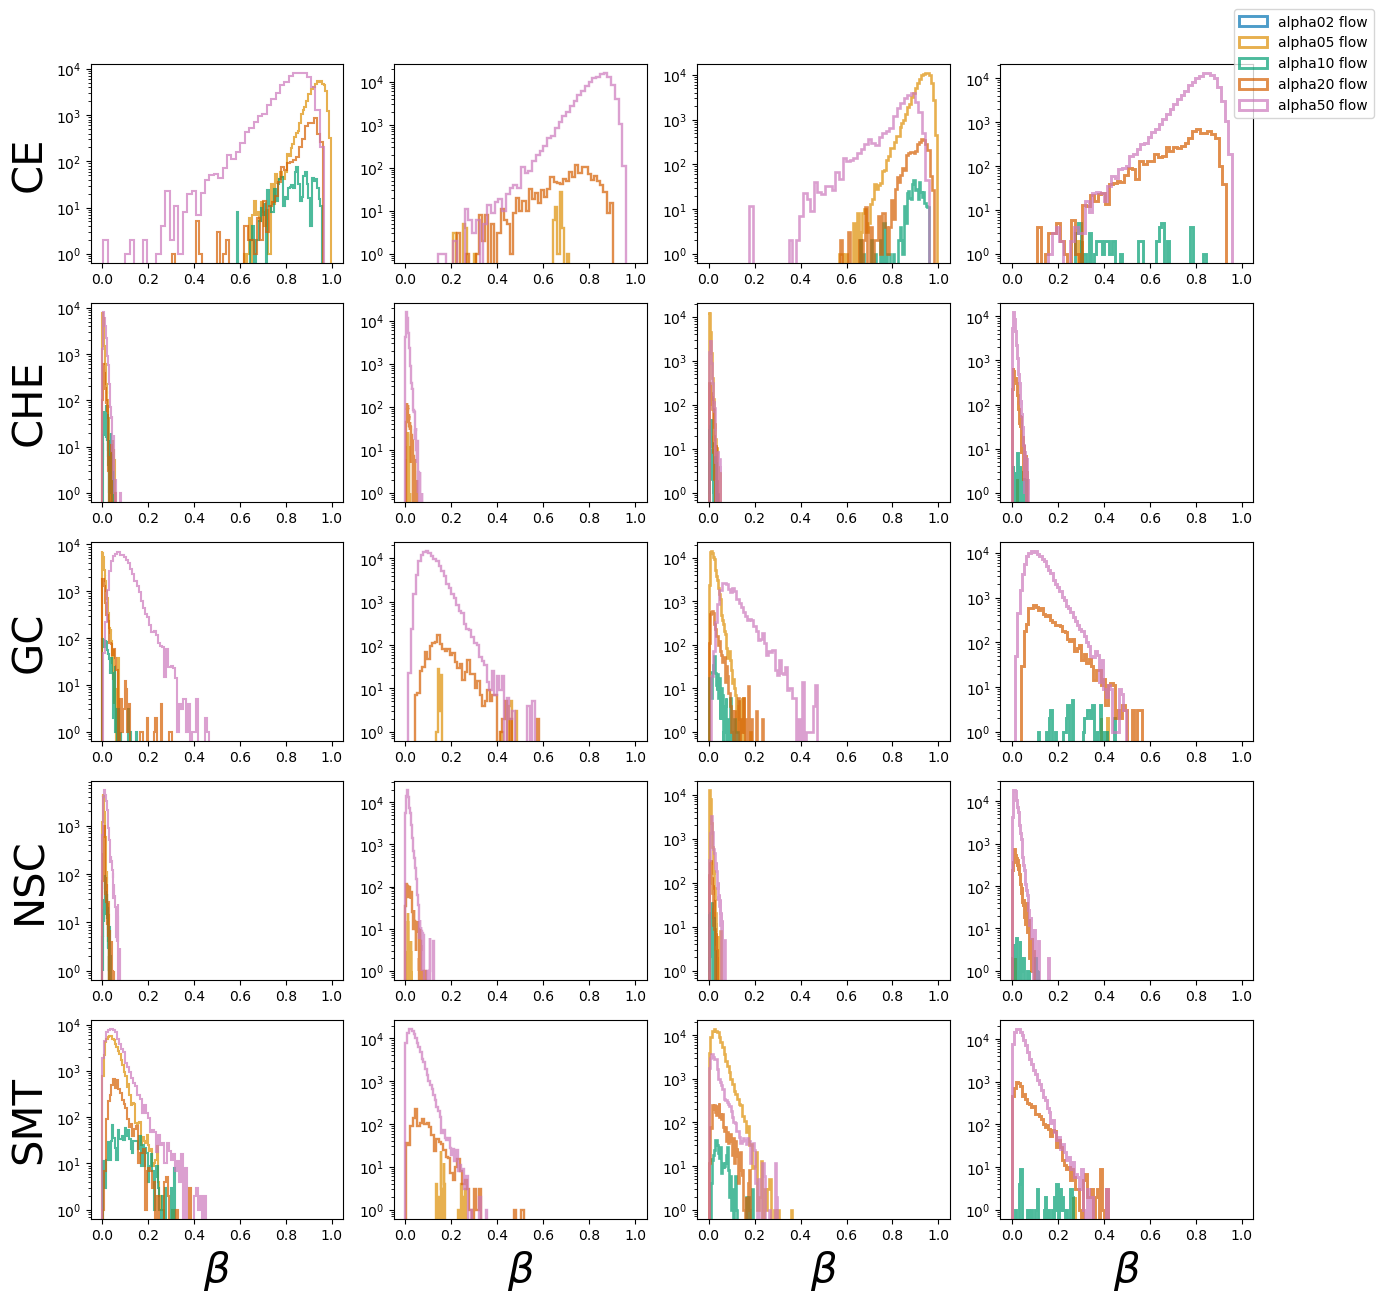

In [13]:
plot_BFs_seeds(['Flows_200624_Gwtc3/output_seed314.hdf5',
 'Flows_200624_Gwtc3/output_seed12.hdf5',
 'Flows_200624_Gwtc3/output_seed89.hdf5',
 'Flows_200624_Gwtc3/output.hdf5'], labels=[' flow', None])

In [ ]:
detectable_samples = samples.copy()
smdls = list(set([x.split('/',1)[1] for x in model_names]))
# get the conversion factors between the detectable and underlying distributions
for smdl in sorted(smdls):
    detectable_convfacs = []
    for channel in channels:
        detectable_convfacs.append(getFromDict(pop_models, [channel]+smdl.split('/')).alpha)
    detectable_convfacs = np.asarray(detectable_convfacs)
    # loop over hyperparams to get samples in this submodel
    hyperparams = smdl.split('/')
    for idx, param in enumerate(hyperparams):
        hyper_idx = list(submodels_dict[idx].keys())[list(submodels_dict[idx].values()).index(param)]
        if idx==0:
            matching_idxs = np.where(samples[:,idx] == hyper_idx)[0]
            matching_samps = samples[matching_idxs]
        else:
            matching_idxs = matching_idxs[np.where(matching_samps[:,idx] == hyper_idx)[0]]
            matching_samps = samples[matching_idxs]
    # if no samples are in this model, continue
    if len(matching_idxs)==0:
        continue
    # convert hyperparams of these samples accordingly to get the underlying betas
    converted_betas = detectable_samples[matching_idxs,len(hyperparams):] * detectable_convfacs
    converted_betas /= converted_betas.sum(axis=1, keepdims=True)
    detectable_samples[matching_idxs,len(hyperparams):] = converted_betas